Código disponível [na minha página do Github](https://github.com/arthurkenzo/atividades_ia525)

## Questão 1:

Usaremos o conjunto de dados Iris para esse exercício, separando os conjuntos de treino e teste em 2/3 e 1/3 do total de amostras respectivamente. Devemos tomar cuidado para balancear a amostragem de forma a equilibrar a representação de cada classe de flor nos dois conjuntos.

## Implementação:

In [293]:
import cvxpy as cp
import numpy as np
import mosek
import matplotlib.pyplot as plt
import time
import networkx as nx
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix



from typing import Tuple

### Pré-processamento dos dados

In [294]:
def GetIndicatorLabels(df:pd.DataFrame) -> pd.DataFrame:
    """ Returns a dataframe where for each column i, the value of each entry is '+1' if the entry is in class i,
        and '-1' if it isn't. Assumes labels are at the last column of the input DataFrame. 

    Returns:
        pd.DataFrame: DataFrame containing label indicator variables for each label in the input  
    """
    labels = df.iloc[:, -1] 
    indicatorLabels = pd.DataFrame({f"class{label}": df[4].apply(lambda x: 1 if x == label else -1) for label in labels})

    return indicatorLabels

In [ ]:
# loading dataset into a pandas dataframe
df = pd.read_csv('iris.data', header=None)

# adding a column of '1's to the features to model the linear coeficient
df.insert(0, 'id', 1)

# transform string labels into integer indexes
df[4], _ = pd.factorize(df[4])

# getting label indicator values for training each individual classifier
labels = GetIndicatorLabels(df)
df = pd.concat([df, labels], axis=1)

print("Pre-processed DataFrame:\n", df)

# Iris-setosa, Iris-versicolor, Iris-virginica

Pre-processed DataFrame:
      id    0    1    2    3  4  class0  class1  class2
0     1  5.1  3.5  1.4  0.2  0       1      -1      -1
1     1  4.9  3.0  1.4  0.2  0       1      -1      -1
2     1  4.7  3.2  1.3  0.2  0       1      -1      -1
3     1  4.6  3.1  1.5  0.2  0       1      -1      -1
4     1  5.0  3.6  1.4  0.2  0       1      -1      -1
..   ..  ...  ...  ...  ... ..     ...     ...     ...
145   1  6.7  3.0  5.2  2.3  2      -1      -1       1
146   1  6.3  2.5  5.0  1.9  2      -1      -1       1
147   1  6.5  3.0  5.2  2.0  2      -1      -1       1
148   1  6.2  3.4  5.4  2.3  2      -1      -1       1
149   1  5.9  3.0  5.1  1.8  2      -1      -1       1

[150 rows x 9 columns]


### Separando conjuntos de treino e teste com split 70/30

O array de labels consiste em 4 colunas:
- A primeira coluna contém o label da classe em forma de índice {0, 1, 2}.
- As próximas três colunas contém variáveis indicatrizes de cada classe separadamente: +1 se o item pertence à classe da coluna, -1 se não pertence. 

In [ ]:
# separating labels from the feature data
totalSamples = len(df.values)
nbSamplesTest = int(np.ceil(totalSamples*0.3))
nbSamplesTrain = int(totalSamples - nbSamplesTest)

nbFeatures = 5
nbLabels = 3

# creating balanced train and test sets.
labels = df.iloc[:, -4:].values
features = df.iloc[:, :5].values

featureTrain, featureTest, labelTrain, labelTest = train_test_split(
features, labels,
test_size=nbSamplesTest,
random_state=1,
stratify=labels )

### Construindo classificadores com métodos de mínimos quadrados e SVM

In [297]:
# these arrays stores the coefficients for the linear separator of each single class classifier
optimalCoefficientsLS = np.zeros((5, 3))
optimalCoefficientsSVM = np.zeros((5, 3))


for i in range(3):

    # building the least squares problem and solving it for each single class classifier
    aLS = cp.Variable(5)
    objectiveLS = cp.Minimize(cp.sum_squares( labelTrain[:, i+1] - featureTrain @ aLS ))

    problemLS = cp.Problem(objectiveLS)
    problemLS.solve(solver="MOSEK", verbose=False)

    if problemLS.status == cp.OPTIMAL:
        print("Class {} least squares classifier:".format(i))
        print("Optimum: ", problemLS.value)
        print("Linear separator coefficients:", aLS.value, "\n")
        optimalCoefficientsLS[:, i] = aLS.value


    # building the SVM problem and solving it for each single class classifier
    aSVM = cp.Variable(5)
    auxMax = cp.Variable(nbSamplesTrain)
    objectiveSVM = cp.Minimize(cp.sum(auxMax))

    constraints = [ auxMax >= 0 ]
    constraints += [ auxMax >= 1 - cp.multiply(labelTrain[:, i+1], (featureTrain @ aSVM)) ]

    problemSVM = cp.Problem(objectiveSVM, constraints)
    problemSVM.solve(solver="MOSEK", verbose=False)

    if problemSVM.status == cp.OPTIMAL:
        print("Class {} SVM classifier:".format(i))
        print("Optimum: ", problemSVM.value)
        print("Linear separator coefficients:", aSVM.value, "\n")
        optimalCoefficientsSVM[:, i] = aSVM.value

Class 0 least squares classifier:
Optimum:  8.381290581473772
Linear separator coefficients: [-1.05605974  0.24528254  0.43073062 -0.52586281 -0.03619552] 

Class 0 SVM classifier:
Optimum:  1.7180683264950147e-10
Linear separator coefficients: [-0.19629453  0.26878485  0.68161222 -1.12816213 -0.20652067] 

Class 1 least squares classifier:
Optimum:  66.93191285071592
Linear separator coefficients: [ 3.26034302 -0.4632782  -0.68596998  0.66380024 -1.07848661] 

Class 1 SVM classifier:
Optimum:  56.52518756704588
Linear separator coefficients: [11.52304394 -1.95069668 -1.95069668  2.27224009 -3.25830654] 

Class 2 least squares classifier:
Optimum:  35.27867606906163
Linear separator coefficients: [-3.20428325  0.21799566  0.25523936 -0.13793744  1.11468212] 

Class 2 SVM classifier:
Optimum:  5.23157894744486
Linear separator coefficients: [-27.04210526  -1.05263158  -5.78947368   5.36842105  13.89473684] 



### Calculando previsões das classes do conjunto de teste

In [298]:
predictionLS = np.argmax(featureTest @ optimalCoefficientsLS, axis=1)
predictionSVM = np.argmax(featureTest @ optimalCoefficientsSVM, axis=1)
print("Predicted indexes (least squares):\n", predictionLS)
print("Predicted indexes (SVM):\n", predictionSVM)

Predicted indexes (least squares):
 [2 0 0 1 2 1 1 1 2 0 0 2 0 1 0 2 2 1 2 2 2 0 2 2 1 2 1 2 0 2 0 0 1 1 2 2 0
 0 0 2 2 2 2 0 0]
Predicted indexes (SVM):
 [2 0 0 1 0 1 2 1 2 0 0 2 0 1 0 1 2 1 1 2 2 0 0 2 1 1 1 2 0 2 0 0 1 1 2 2 0
 0 0 0 2 2 1 0 0]


### Calculando as acurácias e matrizes de confusão para os dois métodos

In [299]:
accuracyLS = accuracy_score(labelTest[:, 0], predictionLS)
accuracySVM = accuracy_score(labelTest[:, 0], predictionSVM)
print("Test Accuracy (least squares):", accuracyLS)
print("Test Accuracy (SVM):", accuracySVM)

Test Accuracy (least squares): 0.8
Test Accuracy (SVM): 0.9111111111111111


In [300]:
accuracyLS = confusion_matrix(labelTest[:, 0], predictionLS)
accuracySVM = confusion_matrix(labelTest[:, 0], predictionSVM)
print("Confusion matrix (least squares):\n", accuracyLS)
print("Confusion matrix (SVM):\n", accuracySVM)


Confusion matrix (least squares):
 [[15  0  0]
 [ 0  8  7]
 [ 0  2 13]]
Confusion matrix (SVM):
 [[15  0  0]
 [ 3 12  0]
 [ 0  1 14]]


### Breve análise das performances dos dois classificadores

Vemos à partir dos experimentos anteriores que o classificador baseado em SVM teve uma acurácia maior no conjunto de teste, obtendo resultados mais precisos para todas as três classes de flores. No entanto, podemos observar aqui a diferença de um classificador "duro" (mínimos quadrados) de um utilizando soft margin (SVM). 

O primeiro classificador conseguiu separar com 100% de precisão todos os itens pertencentes à primeira classe de flor (_iris-setosa_), sendo um indício de que, ao menos nos dados diponíveis, essa espécie de planta é linearmente separável das outras duas (se não me engano isso realmente é o caso para o conjunto Iris). No entanto, a sua performance na separação das outras duas classes foi menor do que a do classficador com soft margin, como pode-se observar das matrizes de confusão. 

Isso se deve ao fato de que as duas outras classes de flor (_iris-versicolor_, _iris-virginica_) não são linearmente separáveis, havendo sobreposição das "áreas" ocupadas por cada classe no espaço de atributos. Isso pode ser ilustrado pelos plots a seguir, onde vemos as relações entre dois pares de atributos diferentes. Em ambos os casos (e na verdade em todos os outros possíveis pares de atributos), os elementos de _iris-setosa_ se encontram bem separados dos outros, enquanto as outras duas espécies não são separáveis por uma simples reta nos plots. 

Isso torna o uso de um classificador com soft margin mais interessante, pois permite uma maior flexibilidade na definição do separador linear entre as duas classes com sobreposição. O lado negativo disso, no entanto, é o fato disso permitir maiores erros de classificação envolvendo a classe linearmente separável, visto por exemplo no item (2,1) da matriz de confusão do SVM. Aqui, os benefícios da classificação melhorada entre _iris-versicolor_ e _iris-virginica_ compensam a perda de precisão na _iris-setosa_, e o SVM acaba ficando com precisão global significativamente melhor que o classificador por mínimos quadrados.

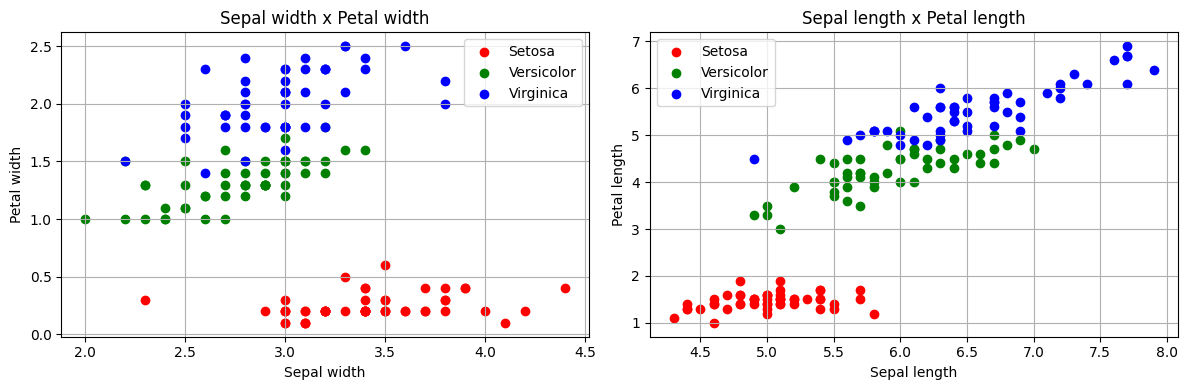

In [301]:
# class color mapping
labels = df[4].values  
label_colors = {0: 'red', 1: 'green', 2: 'blue'}
label_names = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}
featureNames = {0: 'Sepal length', 1: 'Sepal width', 2: 'Petal length', 3: 'Petal width'}

# two different plots ilustrating relationships between features
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

# first plot
x = df[1].values
y = df[3].values
for label in np.unique(labels):
    axes[0].scatter(
        x[labels == label],
        y[labels == label],
        color=label_colors[label],
        label=label_names[label]
    )
axes[0].set_title("Sepal width x Petal width")
axes[0].set_xlabel("Sepal width")
axes[0].set_ylabel("Petal width")
axes[0].legend()
axes[0].grid(True)

# second plot
x = df[0].values
y = df[2].values

for label in np.unique(labels):
    axes[1].scatter(
        x[labels == label],
        y[labels == label],
        color=label_colors[label],
        label=label_names[label]
    )
axes[1].set_title("Sepal length x Petal length")
axes[1].set_xlabel("Sepal length")
axes[1].set_ylabel("Petal length")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()